# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [2]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [3]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [4]:
np.linalg.norm(BB) 

0.36436161983015336

### Do the Jacobi iteration

In [5]:
n_iter = 50
x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [6]:
# Check the result:

A @ x - b

array([ 1.11022302e-16,  0.00000000e+00, -2.22044605e-16, -1.11022302e-16,
        1.11022302e-16,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
       -2.77555756e-17,  1.11022302e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [7]:
 def jacobi_iter_method(A, b, x0, iternum = 1000): 
    temp = A.copy() #A-r matrix
    D = np.diag(np.diag(A))
    D_inv = np.diag(1. / np.diag(A))#inversion
    B = D_inv @ (D - temp)
    if np.linalg.norm(B) >= 1:
        raise ValueError("||B|| >= 1")
    print('B norm = {}'.format(np.linalg.norm(B)))
    c = D_inv @ b #vector
    
    #Iterations
    x = x0
    for i in range(iternum):
        x = B @ x + c
    
    return x

In [8]:
# 1
n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([20] * n)
b = rndm.uniform(size=n)
dif = A @ jacobi_iter_method(A, b, np.ones(n)) - b
print('Test 1, n<= np.diag(A)) ', dif)
# 2, problem
A = rndm.uniform(size=(n, n))
b = rndm.uniform(size=n)
dif = A @ jacobi_iter_method(A, b, np.ones(n)) - b
print('Test 2, n >> np.diag(A) ', dif)

B norm = 0.2787393728878014
Test 1, n<= np.diag(A))  [-1.38777878e-17  1.11022302e-16 -1.11022302e-16  0.00000000e+00
 -1.11022302e-16  5.55111512e-17 -5.55111512e-17  5.55111512e-17
  0.00000000e+00  0.00000000e+00]


ValueError: ||B|| >= 1

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [9]:
def seidel_iter_method(A, b, x0, iternum=50):
    L = np.tril(A)
    U = np.triu(A, 1)
    x = x0
    print('Iter.matrix norm', np.linalg.norm(np.linalg.inv(L) @ U))
    for _ in range(iternum):
        x = np.linalg.inv(L) @ (b - U @ x)
    return x

In [10]:
# 1
n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15] * n)
b = rndm.uniform(size=n)
print('Test 1, n <= np.diag(A)', A @ seidel_iter_method(A, b, np.ones(n)) - b)
# 2
A = rndm.uniform(size=(n, n))
b = rndm.uniform(size=n)
print('Test 2, n >> np.diag(A)', A @ seidel_iter_method(A, b, np.ones(n)) - b)

Iter.matrix norm 0.2593677188931138
Test 1, n <= np.diag(A) [-5.55111512e-17  0.00000000e+00  0.00000000e+00 -2.08166817e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.11022302e-16  0.00000000e+00]
Iter.matrix norm 45.92273965405013
Test 2, n >> np.diag(A) [ 5.58054313e+56 -2.14069014e+56  8.04524875e+56 -1.13579432e+56
  9.98019422e+55  1.01807001e+57  4.67046776e+55 -5.10876298e+56
 -3.58534705e+56  8.71122859e+40]


# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [11]:
def minimal_residual(A, b, x0, tol=1e-15, iternum=np.inf):
    x_true = np.linalg.solve(A, b)
    x = x0
    i = 0
    a_tol = True
    tau = 0
    errors = []
    taus = []
    residual_norms = []
    while a_tol and i < iternum:
        errors = np.append(errors, np.linalg.norm(x - x_true))
        residual = A @ x - b
        delta = A @ residual
        tau = delta @ residual / (delta @ delta)
        taus = np.append(taus, tau)
        residual_norms = np.append(residual_norms, np.linalg.norm(residual))
        
        x -= tau * residual #new x
        residual_0 = A @ x - b #residual for a new x
    
        a_tol = np.linalg.norm(residual - residual_0) > tol
        i += 1
        
    return x, taus, residual_norms, errors 

In [12]:
x_, _, _, _ = minimal_residual(A, b, np.ones(n))
print(A @ x_ - b)


[ 0.21724488  0.45829463  0.00614112 -0.14988833  0.12754904  0.47213199
 -0.0874005   0.22162538 -0.42773492 -0.56486901]


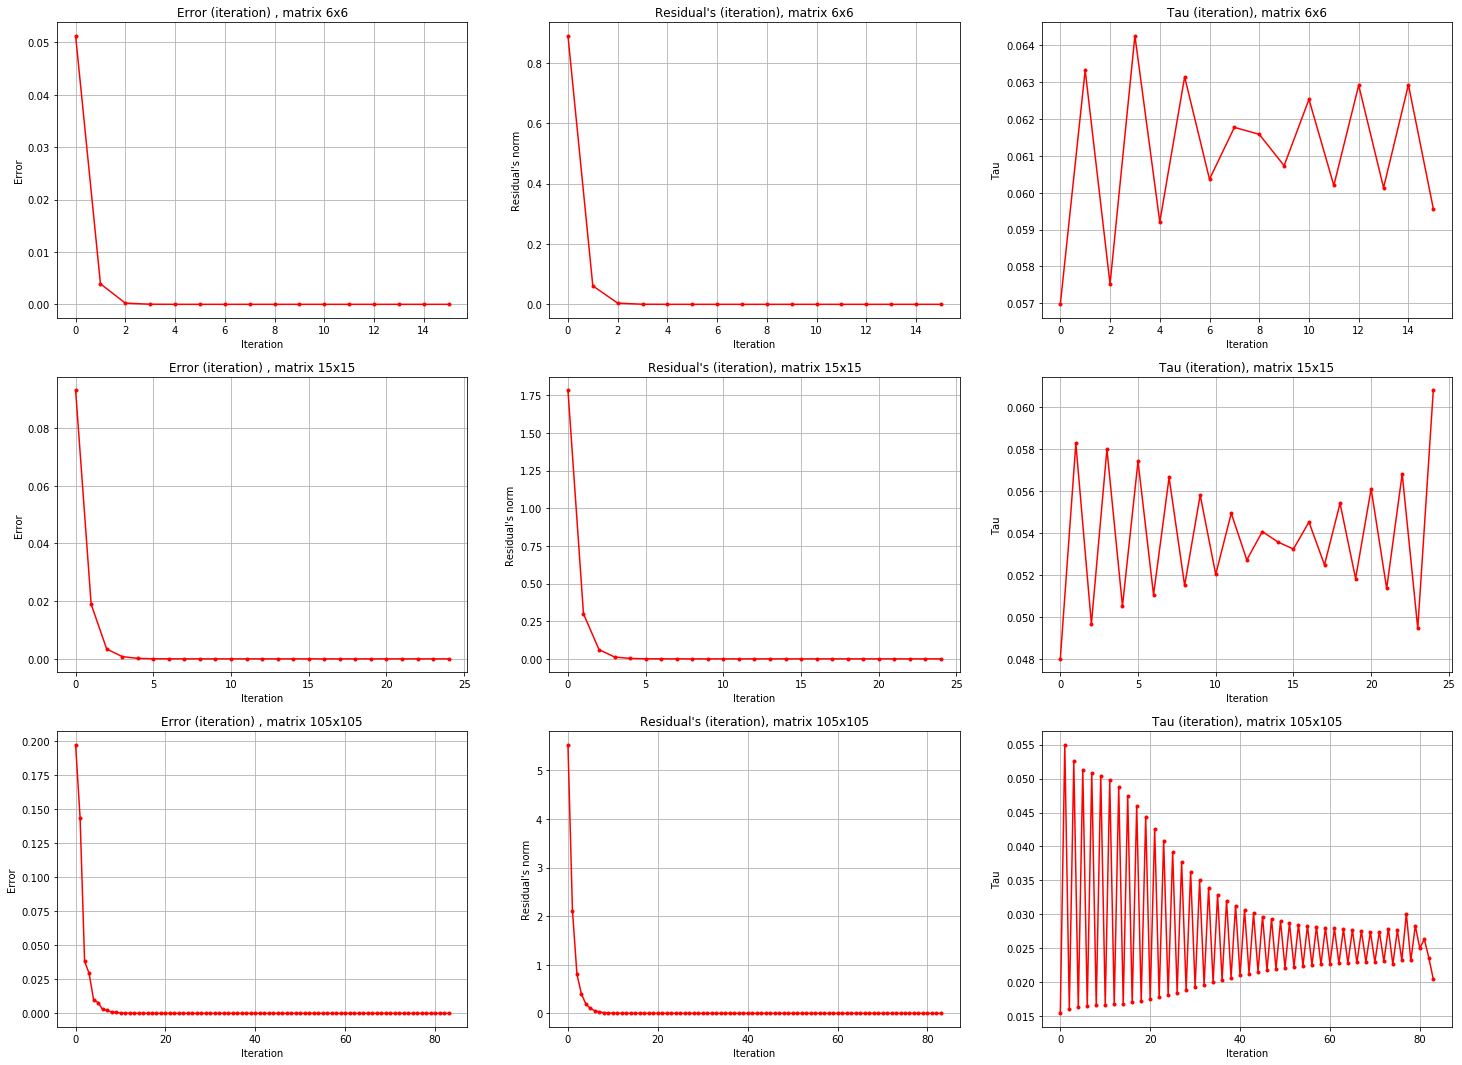

In [20]:
#TESTS AND GRAPHICS
plt.figure(figsize=(25, 25))
diff = []

for i in range(1, 4):
    n = 5 + 10 ** (i-1)
    A_t = np.random.uniform(size = (n, n)) + np.diagflat([15] * (n))
    b_t = np.random.uniform(size = (n))
    
    x, taus, residual_norms, errors = minimal_residual(A_t, b_t, np.zeros_like(b_t), iternum=np.inf)

    diff.append(np.linalg.norm(x - np.linalg.solve(A_t, b_t)))
    
    plt.subplot(4, 3, 3 * i)
    plt.plot(np.arange(taus.size), taus, '.-', color = 'r')
    plt.xlabel('Iteration')
    plt.ylabel('Tau')
    plt.grid()
    plt.title('Tau (iteration), matrix {}x{}'.format(n, n))

    plt.subplot(4, 3, 3 * i - 1)
    plt.plot(np.arange(residual_norms.size), residual_norms, '.-', color = 'r')
    plt.xlabel('Iteration')
    plt.ylabel('Residual\'s norm')
    plt.grid()
    plt.title('Residual\'s (iteration), matrix {}x{}'.format(n, n))

    plt.subplot(4, 3, 3 * i - 2)
    plt.plot(np.arange(errors.size), errors, '.-', color = 'r')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.grid()
    plt.title('Error (iteration) , matrix {}x{}'.format(n, n))
plt.show()
#что-то пошло не так с тау :(

In [14]:
for i in range(1, 4):
    print('Difference for matrix {}x{} is {}'.format(n, n, diff[i - 1]))

Difference for matrix 110x110 is 2.8822653722603806e-17
Difference for matrix 110x110 is 4.788075430074914e-17
Difference for matrix 110x110 is 2.1547418264477492e-16
